Build a model to classify images of two different things you've taken photos of.

You can use any feature extraction layer from TensorFlow Hub you like for this.

You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.

In [1]:
import zipfile

zip_file_path = "guitar_protein.zip"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall()

In [3]:
import os
for dirpath, dirnames, filenames in os.walk("guitar_protein"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'guitar_protein'.
There are 2 directories and 0 images in 'guitar_protein\test'.
There are 0 directories and 5 images in 'guitar_protein\test\guitar'.
There are 0 directories and 5 images in 'guitar_protein\test\protein'.
There are 2 directories and 0 images in 'guitar_protein\train'.
There are 0 directories and 10 images in 'guitar_protein\train\guitar'.
There are 0 directories and 10 images in 'guitar_protein\train\protein'.


In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "C:/Tensorflow/guitar_protein/train"
test_dir = "C:/Tensorflow/guitar_protein/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images")
train_data_guitar_protein = train_datagen.flow_from_directory(train_dir,
                                                              target_size=IMAGE_SHAPE,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode="binary")

print("Testing data")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="binary")


Training images
Found 20 images belonging to 2 classes.
Testing data
Found 10 images belonging to 2 classes.


In [5]:
# Setting up calbacks
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    
    return tensorboard_callback

In [6]:
# Resnet 50v2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [16]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers

def create_model(model_url, num_classes=1):  # Set num_classes to 1 for binary classification
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name="feature_extraction_layer",
                                             input_shape=(224, 224, 3))  # Ensure IMAGE_SHAPE is defined as (224, 224)
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="sigmoid", name="output_layer")  # Sigmoid for binary classification
    ])

    return model


In [17]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"  # Replace with your ResNet URL

# Create the model
resnet_model = create_model(resnet_url, num_classes=1)  # num_classes=1 for binary classification

# Compile the model
resnet_model.compile(loss=tf.keras.losses.binary_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# Define the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="logs/tensorflow_hub/resnet50v2")

# Fit the model
resnet_history = resnet_model.fit(train_data_guitar_protein, 
                                  epochs=10,
                                  steps_per_epoch=len(train_data_guitar_protein),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[tensorboard_callback])


Epoch 1/10
1/1 [==============================] - 47s 47s/step - loss: 0.6820 - accuracy: 0.5500 - val_loss: 0.5878 - val_accuracy: 0.8000
Epoch 2/10
1/1 [==============================] - 24s 24s/step - loss: 0.5090 - accuracy: 0.7500 - val_loss: 0.4470 - val_accuracy: 0.8000
Epoch 3/10
1/1 [==============================] - 24s 24s/step - loss: 0.3726 - accuracy: 0.9500 - val_loss: 0.3359 - val_accuracy: 0.8000
Epoch 4/10
1/1 [==============================] - 24s 24s/step - loss: 0.2694 - accuracy: 1.0000 - val_loss: 0.2506 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 23s 23s/step - loss: 0.1938 - accuracy: 1.0000 - val_loss: 0.1866 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 24s 24s/step - loss: 0.1399 - accuracy: 1.0000 - val_loss: 0.1395 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 23s 23s/step - loss: 0.1018 - accuracy: 1.0000 - val_loss: 0.1053 - val_accuracy: 1.0000
Epoch 8/10
1/1 [===========

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Plot the validation and training curves
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel('epochs')
    plt.legend()

    # Plot the accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

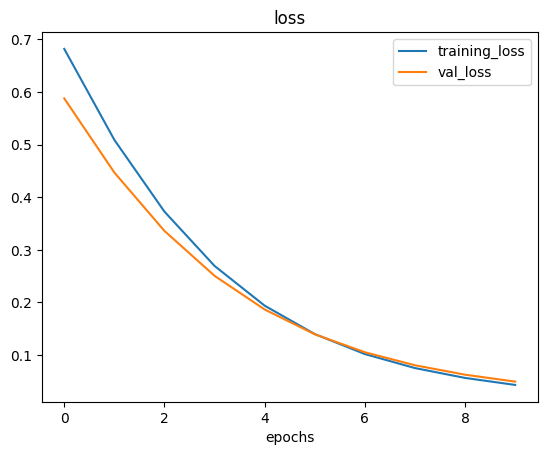

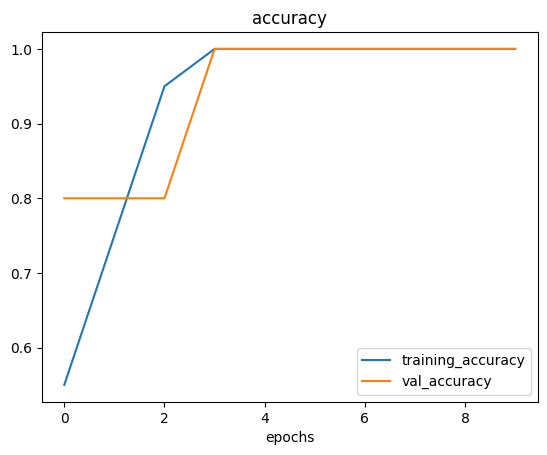

In [19]:
plot_loss_curves(resnet_history)

In [20]:
resnet_model.evaluate(test_data)

c:\Users\bharg\anaconda3\envs\py310\lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 8s 8s/step - loss: 0.0495 - accuracy: 1.0000


[0.049491215497255325, 1.0]

In [21]:
from tensorflow.keras.utils import load_img

image_path_1 = "C:/Tensorflow/guitar_1.jpg"
image1 = load_img(image_path_1, target_size=(224, 224))  # Resize to fit model input size (adjust as needed)

image_path_2 = "C:/Tensorflow/protein_1.jpg"
image1 = load_img(image_path_2, target_size=(224, 224))

c:\Users\bharg\anaconda3\envs\py310\lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [22]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)

    img = tf.image.decode_image(img)

    img = tf.image.resize(img, size=[img_shape, img_shape])
    
    img = img/255.

    return img

In [25]:
import pathlib
import numpy as np
data_dir = pathlib.Path("guitar_protein/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['guitar' 'protein']


In [26]:
class_names

array(['guitar', 'protein'], dtype='<U7')

In [27]:
def pred_and_plot(model, filename, class_names=class_names):
    """
    Imports an image and located at filename, makes a prediction with model
    and plots the image with the predicted class as the title
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    print(len(pred[0]))
    print(tf.argmax(pred))
    # Make logic for multi class
    if len(pred[0]) > 1:
        pred_class = class_names[tf.argmax(pred[0])]
    else:
        pred_class = class_names[int(tf.round(pred[0]))]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

1/1 [==============================] - 2s 2s/step
1
tf.Tensor([0], shape=(1,), dtype=int64)


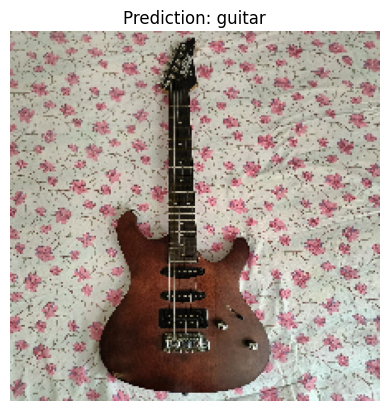

In [28]:
pred_and_plot(model=resnet_model, filename="guitar_1.jpg",
              class_names=class_names)

1/1 [==============================] - 0s 81ms/step
1
tf.Tensor([0], shape=(1,), dtype=int64)


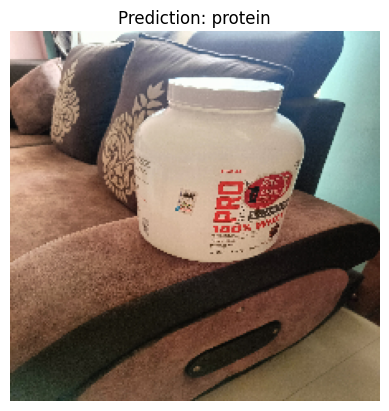

In [29]:
pred_and_plot(model=resnet_model, filename="protein_1.jpg",
              class_names=class_names)